In [2]:
import os
import random
import shutil, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl
from matplotlib.pyplot import figure
from collections import Counter

from os import listdir
from os.path import isfile, join

import cv2
from imutils import paths
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
truth_file = pd.read_csv('../data/test_labels4-1.csv')
truth_file = truth_file.rename(columns = {'TRIGGER_ID': 'event_id',
                                               'CLASS_SPECIES': 'true_class',
                                               'Total': 'true_count',
                                               'CLASS_SPECIES_RESTATED': 'true_class_name'})

truth_file_no_other = truth_file[(truth_file['true_class_name'] != 'other')]

In [3]:
labels = pd.DataFrame(['foxgray_foxred',
              'cottontail_snowshoehare',
              'raccoon',
              'opossum',
              'turkey',
              'bear',
              'elk',
              'deer',
              'coyote',
              'wolf']).sort_values(0)
labels = labels.rename(columns = {0: 'species'})
labels.insert(0, 'class', range(0, len(labels)))

# Phase 1- Blank

## Yolo

In [11]:
#Read lines from txt results file

top_path = '../results/JSON_txt_outputs/'
yolo_file = 'phase1_yolo_yolosplits4_1.txt'
effnet_file = 'phase1_efficientnetb0_classifications_yolosplits_4-1.json'


In [42]:


def images_to_events(image_df, image_id_col = 'id'):
    '''Convert images to events'''

    return image_df['id'].apply(lambda x: x[:-5] if 'SSWI' in x else x.split('_')[0])

def group_events(prediction_image_df):
    '''Convert predictions in terms of events'''
    prediction_event_df = pd.pivot_table(prediction_image_df, index = 'event_id',
              columns = 'class_name',
              values = 'class',
              aggfunc=len, fill_value=0).reset_index() #len(x.unique())).fillna(0)
    return prediction_event_df

def interpret_event_predictions(prediction_event_df):
    return prediction_event_df.apply(lambda x : 'empty' if x['animal'] == 0 else 'animal', axis = 1)

def conf_score_calcs(stage_1, stage_1_pivot, model_type):
    animal_event_ids = stage_1_pivot[~(stage_1_pivot['event_prediction'] == 'empty')]['event_id']
    stage_1_animal = stage_1[stage_1['event_id'].isin(animal_event_ids)]
    stage_1_animal[stage_1_animal['class_name'] == 'animal']
    stage_1_animal_conf = stage_1_animal[['event_id','conf']].groupby('event_id').mean()

    stage_1_blank = stage_1[~stage_1['event_id'].isin(animal_event_ids)]
    stage_1_blank_conf = stage_1_blank[['event_id','conf']].groupby('event_id').mean()

    effnet_conf_scores = pd.concat([stage_1_animal_conf, stage_1_blank_conf])

    return effnet_conf_scores

## YOLO
def yolo_blank_read_file(top_path, yolo_file):
    '''Convert Yolo txt file to predictions df by event'''

    with open(top_path + yolo_file, 'r') as f:
        blank_yolo_lines = f.readlines()

    yolo_image_prediction_list = []
    yolo_blank_prediction_list = []


    for line in blank_yolo_lines:

        image_name = line.split('Filename: ')[1].split('; ')[0]
        prediction = line.split('; ')[1].split('; Bbox[list]')[0]

        yolo_image_prediction_list.append(image_name)
        yolo_blank_prediction_list.append(prediction)

    yolo_stage_1_prediction_df = pd.DataFrame({'id': yolo_image_prediction_list, 'image_prediction': yolo_blank_prediction_list})

    #Create necessary columns
    yolo_stage_1_prediction_df['event_id'] = images_to_events(yolo_stage_1_prediction_df)
    yolo_stage_1_prediction_df['class_name'] = yolo_stage_1_prediction_df['image_prediction'].apply(lambda x: 'empty' if x == '' else 'animal')
    yolo_stage_1_prediction_df['class'] = yolo_stage_1_prediction_df['class_name'].apply(lambda x: 0 if x == 'animal' else 1)

    yolo_stage_1_prediction_grouped = group_events(yolo_stage_1_prediction_df)

    yolo_stage_1_prediction_grouped['event_prediction'] =  interpret_event_predictions(yolo_stage_1_prediction_grouped)

    return yolo_stage_1_prediction_grouped

## Efficientnet
def effnet_blank_read_file(top_path, effnet_file):
    '''Convert Effnet json file to predictions df by event'''

    effnet_stage_1 = pd.read_json(top_path + effnet_file)
    effnet_stage_1 = effnet_stage_1['phase1_classification_results'].apply(pd.Series)

    effnet_stage_1['event_id'] = images_to_events(effnet_stage_1)

    effnet_stage_1_grouped = group_events(effnet_stage_1)

    effnet_stage_1_grouped['event_prediction'] =  interpret_event_predictions(effnet_stage_1_grouped)

    conf_scores = conf_score_calcs(effnet_stage_1, effnet_stage_1_grouped, 'effnet')

    effnet_stage_1_pred_conf = pd.merge(effnet_stage_1_grouped, conf_scores,
         how = 'left',
         left_on = 'event_id',
         right_index = True)[['event_id', 'event_prediction', 'conf']]

    return effnet_stage_1_pred_conf

def model_pred_merge(yolo_stage_1_pred_conf, effnet_stage_1_pred_conf):
    '''Merge yolo and effnet predictions into single df '''
    common = effnet_stage_1_pred_conf[effnet_stage_1_pred_conf['event_id'].isin(yolo_stage_1_pred_conf.event_id)]
    common_merged = pd.merge(common, yolo_stage_1_pred_conf,
             on = 'event_id',
             how = 'left')
    common_merged = common_merged.rename(columns = {'event_prediction_x': 'effnet_pred',
                                                   'event_prediction_y': 'yolo_pred'})
    common_merged = common_merged.drop(columns = ['animal', 'empty'])

    return common_merged

def ensemble_pred_logic(ensemble_row, conf_thresh):
    '''Function designed to run lambda, row by row to convert yolo and effnet_file
    preds into ensemble preds. Optimal performance seen when we only overwrite effnet_file
    with yolo on the empties and at a certain threshold'''

    if ensemble_row['effnet_pred'] == 'empty' and ensemble_row['conf'] < conf_thresh:
        ensemble_pred =  ensemble_row['yolo_pred']
    else:
        ensemble_pred = ensemble_row['effnet_pred']

    return ensemble_pred


def main(conf_thresh):
    yolo_stage_1_pred_conf = yolo_blank_read_file(top_path, yolo_file)
    effnet_stage_1_pred_conf = effnet_blank_read_file(top_path, effnet_file)
    merged_stage_1_pred_conf = model_pred_merge(yolo_stage_1_pred_conf, effnet_stage_1_pred_conf)

    merged_stage_1_pred_conf['ensemble_pred'] = merged_stage_1_pred_conf.apply(lambda x: ensemble_pred_logic(x, conf_thresh), axis = 1)

    #merged_stage_1_pred_conf.to_csv('/Users/sleung2/Documents/MIDS Program/capstone/ensemble/merged_stage_1_pred_conf.csv', index = False)

    truth_file['true_blank_class'] = truth_file['true_class'].apply(lambda x: 'empty' if x == 'blank' else 'animal')
    stage1_results_truth = pd.merge(merged_stage_1_pred_conf, truth_file[['event_id','true_blank_class']],
        on = 'event_id')
    
    y_true = stage1_results_truth['true_blank_class']
    y_pred = stage1_results_truth['ensemble_pred']
    
    target_names = label_list
    print(classification_report(y_true, y_pred,  target_names=target_names))
    
    
    return merged_stage_1_pred_conf

#Threshold at which to overwrite effnet with yolo on empty images
conf_thresh_list = [.9]

for conf_thresh in conf_thresh_list:
    merged_stage_1_pred_conf = main(conf_thresh)



              precision    recall  f1-score   support

      animal       0.98      0.97      0.98      1475
       empty       0.81      0.84      0.82       200

    accuracy                           0.96      1675
   macro avg       0.89      0.91      0.90      1675
weighted avg       0.96      0.96      0.96      1675



In [27]:
truth_file['true_blank_class'] = truth_file['true_class'].apply(lambda x: 'empty' if x == 'blank' else 'animal')



In [31]:
stage1_results_truth = pd.merge(merged_stage_1_pred_conf, truth_file[['event_id','true_blank_class']],
        on = 'event_id')

In [38]:


y_true = stage1_results_truth['true_blank_class']
label_list = np.unique(y_true)

for prediction in ['ensemble_pred', 'yolo_pred', 'effnet_pred']:
    y_pred = stage1_results_truth[prediction]
    
    target_names = label_list
    print(classification_report(y_true, y_pred,  target_names=target_names))

              precision    recall  f1-score   support

      animal       0.98      0.96      0.97      1475
       empty       0.77      0.89      0.82       200

    accuracy                           0.95      1675
   macro avg       0.88      0.92      0.90      1675
weighted avg       0.96      0.95      0.96      1675

              precision    recall  f1-score   support

      animal       0.93      0.97      0.95      1475
       empty       0.65      0.47      0.54       200

    accuracy                           0.91      1675
   macro avg       0.79      0.72      0.75      1675
weighted avg       0.90      0.91      0.90      1675

              precision    recall  f1-score   support

      animal       0.99      0.95      0.97      1475
       empty       0.69      0.91      0.79       200

    accuracy                           0.94      1675
   macro avg       0.84      0.93      0.88      1675
weighted avg       0.95      0.94      0.94      1675



# Phase 2- Species

## Yolo

In [4]:
#Read lines from txt results file

toppath = 'phase 2-species/'
txt_file = 'output_yolo_species_splits4.txt'#'output_yolo_species_splits4.txt'

with open(toppath + txt_file, 'r') as f:
    original_lines = f.readlines()

In [5]:
#Txt file to dataframe
#We are taking the TOP confidence score species for each image as the species
#Count is the count for all bounding boxes drawn in image

rows = []

for item in original_lines:
    
    #Class number
    item_split_1 = item.split(' Bbox[list]')[0]
    class_conf_list = item_split_1.split(';')[1:-2]
    
    conf_score_max = 0
    
    i = 0    
    for class_conf in class_conf_list:
        conf_score_int = float(class_conf.split(',Conf:')[1])
        
        
        if conf_score_int > conf_score_max:
            conf_score_max = conf_score_int
            max_index = i
            
        i += 1
    try:
        class_string = class_conf_list[max_index].split(',')[0]
        class_num = float(class_string.split(':')[1])
        class_num = int(class_num)
    except:
        class_num = 'Blank'

    #Counts
    count_split_1 = item.split(' Bbox[list]')[-1]
    count_split_2 = count_split_1.replace(';', ',')  
    count_split_3 = count_split_2.split(',')
    count = int((len(count_split_3)-1)/4)
        
    #Filename
    file_split_1 = item.split('Filename: ')[1]
    file_name = file_split_1.split(';')[0].split('.jpg')[0]
        
    row = [file_name, class_num, count, conf_score_max]
    
    rows.append(row)       

predictions = pd.DataFrame(rows, columns = ['filename', 'class', 'count', 'conf_score_max'])

Species
1. Events with multiple images of same class will be labeled the majority class
- For event to be labeled Blank, all images must be blank
2. Events with all different labels will get labelled with highest confidence score 

Counts
1. Events with multiple images of same class- we will take the max of the majority class
2. Events with all different labels will get labelled with the count of highest conf score label


In [6]:
#Event column- remove A,B,C appendix
predictions['event_id'] = predictions['filename'].str[:-1]


## Events with muliple images of same class
#Species determination
#Groupby event, class
event_class_group_count = pd.DataFrame(predictions.groupby(['event_id', 'class']).count()['filename']).reset_index().rename(columns = {'filename': 'count_rows'})

#Filter by rows that have count greater than 1
event_class_group_count_majority = event_class_group_count[event_class_group_count['count_rows'] > 1]

#Remove blank events that are not a consensus for all 3 images
event_class_group_count_majority = event_class_group_count_majority[~((event_class_group_count_majority['class'] == 'Blank') &
                                (event_class_group_count_majority['count_rows'] < 3))]

#Count determination
event_class_group_majority_counts = pd.merge(predictions, event_class_group_count_majority,
         how = 'inner',
         on = ['event_id', 'class'])

event_class_majority_counts = event_class_group_majority_counts[['event_id', 'count']].groupby(['event_id']).max().reset_index()

event_max_conf_score = event_class_group_majority_counts[['event_id', 'conf_score_max']].groupby(['event_id']).max().reset_index()

majority_df = pd.merge(event_class_majority_counts, event_class_group_count_majority,
         on = 'event_id',
         how = 'left')[['event_id', 'count','class']]

majority_df = pd.merge(majority_df, event_max_conf_score,
         on = 'event_id',
         how = 'left')

## Events with all different labels
predictions_single_count = predictions[~predictions['event_id'].isin(majority_df['event_id'])]

event_list = []
pred_list = []
count_list = []
conf_score_max_list = []

previous_event = ''
conf_score_group_max = 0
pred_class = ''
conf_score_group_max = 0

predictions_single_count_grouped = predictions_single_count.groupby(['event_id', 'class',
                                                                     'conf_score_max'])

for group_name, group in predictions_single_count_grouped:
        
    current_event = group_name[0]
    current_class = group['class'].iloc[0]
    current_conf_score = group['conf_score_max'].iloc[0]
    current_count = group['count'].iloc[0]
    
    #Check if we are looking at a new event
    if current_event != previous_event:
        conf_score_max_list.append(conf_score_group_max)
        conf_score_group_max = 0
        event_list.append(previous_event)
        pred_list.append(pred_class)
        count_list.append(current_count)
        
    if conf_score_group_max < current_conf_score:
        pred_class = current_class
        conf_score_group_max = current_conf_score
        
    previous_event = current_event 

conf_score_max_list.append(conf_score_group_max)
event_list.append(previous_event)
pred_list.append(pred_class)
count_list.append(current_count)
    
single_class_df = pd.DataFrame(list(zip(event_list,
              pred_list,
              count_list,
              conf_score_max_list)),
            columns = ['event_id', 'class', 'count','conf_score_max'])

predictions_by_events_df = pd.concat([majority_df, single_class_df])


yolo_predictions_by_events_df = pd.merge(predictions_by_events_df, labels,
         how = 'left',
         on = 'class')

truth_pred_yolo_df = pd.merge(truth_file_no_other, yolo_predictions_by_events_df,
                         how = 'left',
                         left_on = 'event_id',
                         right_on = 'event_id')
yolo_preds_df = truth_pred_yolo_df[['event_id', 'class', 'conf_score_max', 'count', 'species']]

yolo_preds_df = yolo_preds_df.rename(columns = {'class': 'pred_class',
                                               'conf_score_max': 'conf_score',
                                                'count': 'pred_count',
                                               'species': 'pred_class_name'})




In [7]:
yolo_preds_df = yolo_preds_df.rename(columns = {'pred_class': 'pred_class_yolo',
                                                   'conf_score': 'conf_score_yolo',
                                                   'pred_count': 'pred_count_yolo',
                                                   'pred_class_name': 'pred_class_name_yolo'})


In [8]:
ensemble_pred_df = yolo_preds_df

In [14]:
ensemble_result_metrics = pd.merge(truth_file_no_other_no_blank, ensemble_pred_df,
         how = 'left',
         on = ['event_id'])



## Blur Detection

In [32]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--images", required=True,
#     help="path to input directory of images")
# ap.add_argument("-t", "--threshold", type=float, default=100.0,
#     help="focus measures that fall below this value will be considered 'blurry'")
# args = vars(ap.parse_args())
# print()

IMG_ROOT =  '/Users/sleung2/Documents/MIDS Program/Capstone_local/snapshot_wisconsin/all/yolo_splits4.1'
d = {'filename':[], 'blurry':[], 'blurry_index':[]}


# loop over the input images
for imagePath in paths.list_images(os.path.join(IMG_ROOT, "test", "images")):
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    image = cv2.imread(imagePath)
    filename = imagePath.split("/")[-1]
#     print(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    threshold = 100
    text = "Not Blurry"
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < threshold:
        text = "Blurry"
        d['filename'].append(filename)
        d['blurry'].append(True)
        d['blurry_index'].append(fm)
        cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)

    else: 
        d['filename'].append(filename)
        d['blurry'].append(False)
        d['blurry_index'].append(fm)
        cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)

    
    # show the image
#     cv2.putText(image, "{}: {:.2f}".format(text, fm), (10, 30),
#         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
#     cv2.imshow("Image", image)
    #key = cv2.waitKey(0)
    
df = pd.DataFrame(d)
# df.to_excel('test_blurry.xlsx')

In [33]:
df

,filename,blurry,blurry_index
0,SSWI000000019581852B.jpg,False,1280.657819
1,SSWI000000017053464A.jpg,False,4042.022707
2,SSWI000000017956566C.jpg,False,479.406418
3,SSWI000000020365431C.jpg,False,2309.039980
4,SSWI000000020143634C.jpg,True,40.220804
...,...,...,...
4956,SSWI000000008123783C.jpg,False,1567.544772
4957,SSWI000000021269107A.jpg,False,2567.941424
4958,SSWI000000015119592C.jpg,False,2390.611537
4959,SSWI000000012002832B.jpg,False,5150.621492


In [38]:
#Event column- remove A,B,C appendix
df['event_id'] = df['filename'].apply(lambda x: x[:-5] if 'SSWI' in x else x[:-8])


## Events with muliple images of same class


In [41]:
#Species determination
#Groupby event, class
blurry_event_class_group_count = pd.DataFrame(df.groupby(['event_id', 'blurry']).count()['filename']).reset_index().rename(columns = {'img_id': 'count_rows'})


In [47]:
blurry_events = blurry_event_class_group_count[(blurry_event_class_group_count['blurry'] == True) &
                              ~(blurry_event_class_group_count['filename'] != 3)]

In [49]:
ensemble_result_metrics_blur = pd.merge(ensemble_result_metrics, blurry_events,
         how = 'left',
         on = 'event_id')

In [58]:
ensemble_result_metrics_blur = ensemble_result_metrics_blur[ensemble_result_metrics_blur['blurry'].isnull()]

In [59]:
ensemble_result_metrics_drop_null = ensemble_result_metrics_blur.fillna('blank')

In [60]:
y_true = ensemble_result_metrics_drop_null['true_class_name']
label_list = np.unique(y_true)
label_list = np.sort(np.array(list(label_list) + ['blank']))

for prediction in ['pred_class_name_yolo']:#['pred_class_name_effnet', 'pred_class_name_yolo']:
    y_pred = ensemble_result_metrics_drop_null[prediction]
    
    target_names = label_list
    print(classification_report(y_true, y_pred,  target_names=target_names))


                         precision    recall  f1-score   support

                   bear       0.87      0.88      0.87       122
                  blank       0.00      0.00      0.00         0
cottontail_snowshoehare       0.87      0.55      0.67        98
                 coyote       0.66      0.71      0.68       149
                   deer       0.89      0.84      0.86       349
                    elk       0.84      0.94      0.89       182
         foxgray_foxred       0.54      0.67      0.60        69
                opossum       0.97      0.54      0.69        52
                raccoon       0.76      0.66      0.71       118
                 turkey       0.85      0.56      0.68        84
                   wolf       0.74      0.71      0.72       125

               accuracy                           0.76      1348
              macro avg       0.73      0.64      0.67      1348
           weighted avg       0.81      0.76      0.78      1348



/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


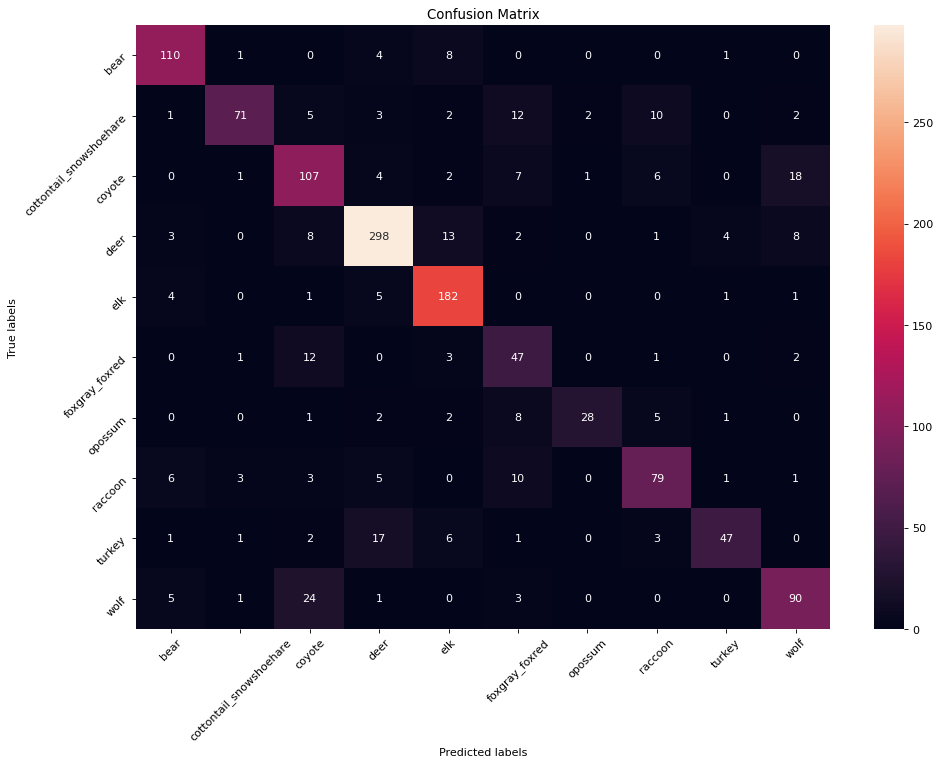

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
import pylab as pl
from matplotlib.pyplot import figure

figure(figsize=(14, 10), dpi=80)


label_list = np.unique(y_true)

cm = confusion_matrix(y_true, y_pred, labels = label_list)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel(
    'True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

plt.show()

In [39]:
df.head(50)

,filename,blurry,blurry_index,event_id
0,SSWI000000019581852B.jpg,False,1280.657819,SSWI000000019581852
1,SSWI000000017053464A.jpg,False,4042.022707,SSWI000000017053464
2,SSWI000000017956566C.jpg,False,479.406418,SSWI000000017956566
3,SSWI000000020365431C.jpg,False,2309.039980,SSWI000000020365431
4,SSWI000000020143634C.jpg,True,40.220804,SSWI000000020143634
5,SSWI000000017771284A.jpg,False,628.780365,SSWI000000017771284
6,SSWI000000022210008C.jpg,False,1243.363524,SSWI000000022210008
7,SSWI000000019326590C.jpg,False,3555.561975,SSWI000000019326590
8,SSWI000000019521649C.jpg,False,1985.128286,SSWI000000019521649
9,SSWI000000010298488A.jpg,False,1281.960938,SSWI000000010298488
